In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
import matplotlib.pyplot as plt

### Data

In [2]:
bc = datasets.load_breast_cancer()

X_bc = bc.data.astype(np.float32)
y_bc = bc.target.astype(np.float32)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_bc, y_bc, test_size = .3, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
class Data(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        self.x = torch.tensor(x)
        self.y = torch.tensor(np.expand_dims(y, 1))
        self.len = self.x.shape[0]
    
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

In [4]:
train_data = Data(X_train, y_train)
batch_size = len(train_data) // 10

In [5]:
trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size)

### Model

In [6]:
class Net(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hidden):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(n_inputs, n_hidden)
        self.linear2 = torch.nn.Linear(n_hidden, 1)
        
    def forward(self, x):
        h    = torch.sigmoid(self.linear1(x))
        yhat = torch.sigmoid(self.linear2(h))
        return yhat

In [7]:
model = Net(X_bc.shape[1], 10)

### Baseline training

In [8]:
objective = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 100
errors_baseline = []

for epoch in range(epochs):
    total_error = 0
    for x, y in trainloader:
        yhat = model(x)
        loss = objective(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_error += loss.data.item()
    yhat = model(torch.tensor(X_test))
    test_error = objective(yhat, torch.tensor(y_test).view(-1, 1)).data.item()
    errors_baseline.append(test_error)

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


### Fast training

Train a k-NN classifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

We need two optimizers

In [11]:
model = Net(X_bc.shape[1], 10)

optimizer_fast = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_slow = torch.optim.Adam(model.parameters(), lr=0.001)

First, we fit the network to k-NN with higher LR

In [12]:
epochs = 10
errors_fast = []

for epoch in range(epochs):
    total_error = 0
    for x, y in trainloader:
        y_hat = model(x)
        # This is how we fit a neural network to k-NN
        #########################################################################################
        y_knn = torch.tensor(knn.predict_proba(x.numpy())[:, 1], dtype=torch.float32).view(-1, 1)
        loss = objective(y_hat, y_knn)
        #########################################################################################
        optimizer_fast.zero_grad()
        loss.backward()
        optimizer_fast.step()
        total_error += loss.item()
    yhat = model(torch.tensor(X_test))
    test_error = objective(yhat, torch.tensor(y_test).view(-1, 1)).data.item()
    errors_fast.append(test_error)

Then, we fit the network to data with usual LR

In [13]:
epochs = 90

for epoch in range(epochs):
    total_error = 0
    for x, y in trainloader:
        y_hat = model(x)
        loss = objective(y_hat, y)
        optimizer_slow.zero_grad()
        loss.backward()
        optimizer_slow.step()
        total_error += loss.item()
    yhat = model(torch.tensor(X_test))
    test_error = objective(yhat, torch.tensor(y_test).view(-1, 1)).data.item()
    errors_fast.append(test_error)

Plot learning curves

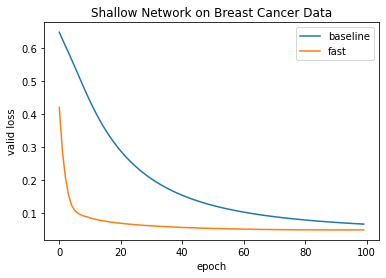

In [14]:
errors = pd.DataFrame({'baseline': errors_baseline, 'fast': errors_fast})
errors.plot()

plt.title('Shallow Network on Breast Cancer Data')
plt.xlabel('epoch')
plt.ylabel('valid loss')

plt.savefig('knn-neural.pdf', format='pdf', dpi=300)